In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logdir
import re
import sys
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
sys.path.append('../content/drive/My Drive/Google Colab/PML/Attention XUnet')

import model
from glob import glob
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
path = '../content/drive/My Drive/Google Colab/PML/pre-trained model/'
decoder_filters = (256, 128, 64, 32)
n_blocks = 4
batch_size = 8
epoch = 32
lr = 0.001
gamma = 0.5
alpha = 0.5

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
early_stop = EarlyStopping(monitor='loss', patience=3)

# Helpers


In [ ]:
def read_data(file_path, mask=False):
  img = nib.load(file_path)
  data = img.get_fdata()
  if mask:
    reverse_channel = np.array([data[:,:,i] for i in 
                                range(data.shape[-1])], dtype='float32')
  else:
    reverse_channel = np.array([adjust_data(data[:,:,i]) for i in 
                                range(data.shape[-1])], dtype='float32')
  return reverse_channel

def add_channel(img, number=3):
  img = np.expand_dims(img, -1)
  img = np.repeat(img, number, -1)
  return img

def adjust_data(img):
  img = (img - np.mean(img))/(np.std(img) + K.epsilon())
  return img

def find_best(path_model, type_='min'):
  path = glob(path_model+'/*.hdf5') 
  split = [i.split('-')[-1] for i in path]
  split.sort(key=natural_keys)
  if type_ == 'min':
    file_ = split[0]
  else:
    file_ = split[-1]
  return [i for i in path if file_ in i] [0]

def show_img(y_true, y_pred, idx=0):
  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1); plt.title('Ground Truth')
  plt.imshow(y_true[idx], cmap='gray'); plt.axis('off')
  plt.subplot(1,2,2); plt.title('Prediction')
  plt.imshow(y_pred[idx,:,:,0], cmap='gray'); plt.axis('off')
  plt.show()

# https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside
def atoi(text):
  return int(text) if text.isdigit() else text

# https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside
def natural_keys(text):
  return [atoi(c) for c in re.split(r'(\d+)', text)]

# https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py#L37
def dice_coef(y_true, y_pred):
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py#L44
def dice_coef_loss(y_true, y_pred):
  return 1. - dice_coef(y_true, y_pred)

# https://github.com/umbertogriffo/focal-loss-keras/blob/master/src/loss_function/losses.py#L11
def binary_focal_loss(gamma=2., alpha=.25):
  def binary_focal_loss_fixed(y_true, y_pred):
    """
    :param y_true: A tensor of the same shape as `y_pred`
    :param y_pred:  A tensor resulting from a sigmoid
    :return: Output tensor.
    """
    y_true = tf.cast(y_true, tf.float32)
    # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
    epsilon = K.epsilon()
    # Add the epsilon to prediction value
    # y_pred = y_pred + epsilon
    # Clip the prediciton value
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    # Calculate p_t
    p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
    # Calculate alpha_t
    alpha_factor = K.ones_like(y_true) * alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
    # Calculate cross entropy
    cross_entropy = -K.log(p_t)
    weight = alpha_t * K.pow((1 - p_t), gamma)
    # Calculate focal loss
    loss = weight * cross_entropy
    # Sum the losses in mini_batch
    loss = K.mean(K.sum(loss, axis=1))
    return loss
  return binary_focal_loss_fixed

# Data


In [ ]:
flair_path = glob('../content/drive/My Drive/Google Colab/PML/ADNI_20x3_2015/*/flair.nii.gz')
label_path = glob('../content/drive/My Drive/Google Colab/PML/ADNI_20x3_2015/*/wmh_label.nii.gz')

img_x = np.concatenate((read_data(flair_path[0]), read_data(flair_path[1])))
seg_x = np.concatenate((read_data(label_path[0], mask=True),
                        read_data(label_path[1], mask=True)))
img_y = read_data(flair_path[2])
seg_y = read_data(label_path[2], mask=True)
img_z = read_data(flair_path[3])
seg_z = read_data(label_path[3], mask=True)

img_x.shape, img_y.shape, img_z.shape

((833, 256, 256), (425, 256, 256), (421, 256, 256))

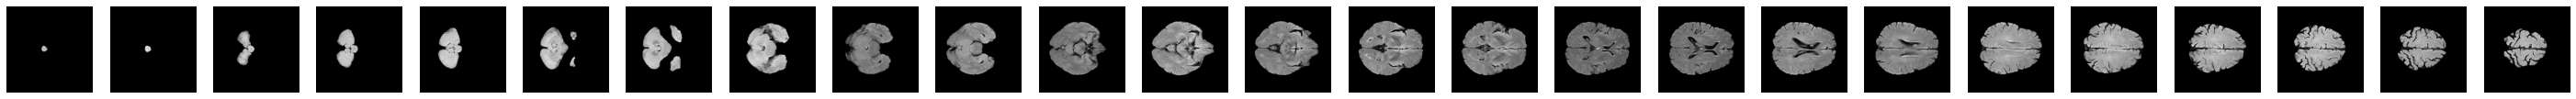

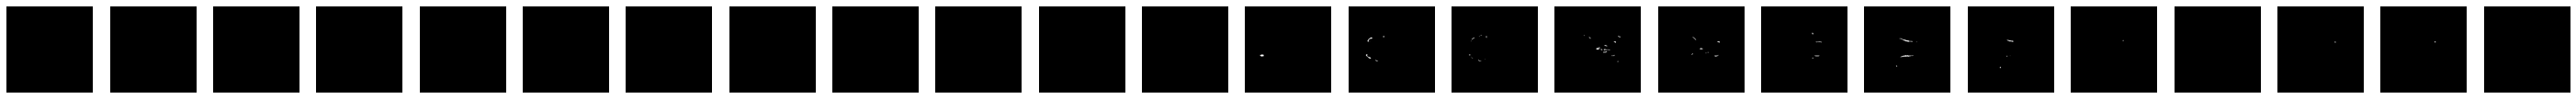

In [ ]:
plt.figure(figsize=(50,50))
for i in range(25):
  plt.subplot(1,25,i+1)
  plt.imshow(img_x[i], cmap='gray'); plt.axis('off')

plt.figure(figsize=(50,50))
for i in range(25):
  plt.subplot(1,25,i+1)
  plt.imshow(seg_x[i], cmap='gray'); plt.axis('off')
plt.show()

In [ ]:
img_train = add_channel(img_x, number=1)
seg_train = add_channel(seg_x, number=1)

img_val = add_channel(img_y, number=1)
seg_val = add_channel(seg_y, number=1)

img_test = add_channel(img_z, number=1)
seg_test = add_channel(seg_z, number=1)

# custom_object = {'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef}
# md_Attdense = load_model(path+'model_Attdense.h5', custom_objects=custom_object)

# 1. Attention Unet++




## 1.1. With Downsampling



In [ ]:
logdir = path+'logdir/AttXnet_paper'

tensorboard = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint(
    filepath=path+'AttXnet_paper/checkpoint-best-{epoch:02d}-{val_loss:.4f}.hdf5',
    monitor='val_loss', mode='min', save_best_only=True)

md_AttXenc_ = model.AttXnet(use_backbone=False, input_shape=(256,256,1),
                            n_upsample_blocks=n_blocks, decoder_filters=decoder_filters)

md_AttXenc_.compile(optimizer=Adam(learning_rate=lr), loss=binary_focal_loss(gamma=gamma, alpha=alpha), metrics=[dice_coef])
 
md_AttXenc_.fit(img_train, seg_train, epochs=epoch, batch_size=batch_size,
                validation_data=(img_val,seg_val), callbacks=[model_checkpoint, reduce_lr, tensorboard])

best_weight = find_best(path+'AttXnet_paper')
md_AttXenc_.load_weights(best_weight)

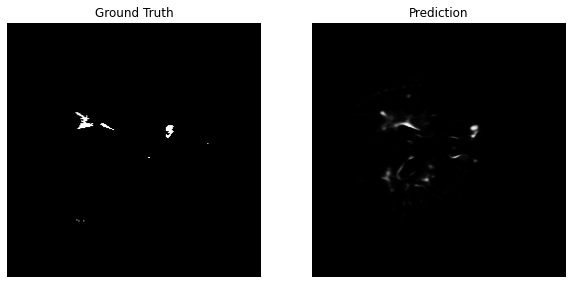

14/14 [==============================] - 12s 881ms/step - loss: 0.2175 - dice_coef: 0.3129


'Model AttX-enc- have total params : 11,970,611'

In [ ]:
y_pred = md_AttXenc_.predict(img_test)
show_img(seg_z, y_pred, 16)
scores = md_AttXenc_.evaluate(img_test, seg_test)
'Model {} have total params : {:,}'.format(md_AttXenc_.name, md_AttXenc_.count_params())

## 1.2. With Downsampling and Deep Supervision



In [ ]:
logdir = path+'logdir/AttXnet_dspaper'

tensorboard = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint(
    filepath=path+'AttXnet_dspaper/checkpoint-best-{epoch:02d}-{val_loss:.4f}.hdf5',
    monitor='val_loss', mode='min', save_best_only=True)

md_AttXencds_ = model.AttXnet(use_backbone=False, input_shape=(256,256,1), deep_supervision=True,
                              n_upsample_blocks=n_blocks, decoder_filters=decoder_filters)

md_AttXencds_.compile(optimizer=Adam(learning_rate=lr), loss=binary_focal_loss(gamma=gamma, alpha=alpha), metrics=[dice_coef])
 
md_AttXencds_.fit(img_train, seg_train, epochs=epoch, batch_size=batch_size,
                  validation_data=(img_val,seg_val), callbacks=[model_checkpoint, reduce_lr, tensorboard])

best_weight = find_best(path+'AttXnet_dspaper')
md_AttXencds_.load_weights(best_weight)

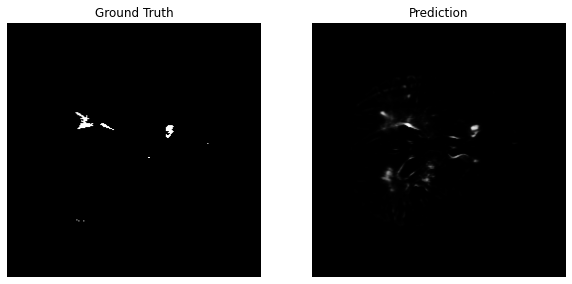

14/14 [==============================] - 12s 816ms/step - loss: 0.2429 - dice_coef: 0.2174


'Model AttX-enc-ds have total params : 11,970,454'

In [ ]:
y_pred = md_AttXencds_.predict(img_test)
show_img(seg_z, y_pred, 16)
scores = md_AttXencds_.evaluate(img_test, seg_test)
'Model {} have total params : {:,}'.format(md_AttXencds_.name, md_AttXencds_.count_params())

## 1.3. Encoder


In [ ]:
logdir = path+'logdir/AttXnet'

tensorboard = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint(
    filepath=path+'AttXnet/checkpoint-best-{epoch:02d}-{val_loss:.4f}.hdf5',
    monitor='val_loss', mode='min', save_best_only=True)

md_AttXenc = model.Xnet(use_backbone=False, input_shape=(256,256,1), attention=True,
                        n_upsample_blocks=n_blocks, decoder_filters=decoder_filters)

md_AttXenc.compile(optimizer=Adam(learning_rate=lr), loss=binary_focal_loss(gamma=gamma, alpha=alpha), metrics=[dice_coef])
 
md_AttXenc.fit(img_train, seg_train, epochs=epoch, batch_size=batch_size,
               validation_data=(img_val,seg_val),
               callbacks=[model_checkpoint, reduce_lr, tensorboard])

best_weight = find_best(path+'AttXnet')
md_AttXenc.load_weights(best_weight)

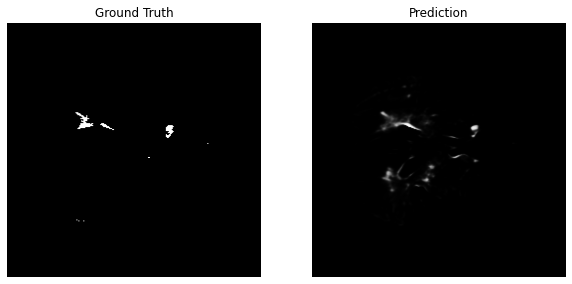

14/14 [==============================] - 13s 803ms/step - loss: 0.2819 - dice_coef: 0.3279


'Model AttX-enc have total params : 11,472,947'

In [ ]:
y_pred = md_AttXenc.predict(img_test)
show_img(seg_z, y_pred, 16)
scores = md_AttXenc.evaluate(img_test, seg_test)
'Model {} have total params : {:,}'.format(md_AttXenc.name, md_AttXenc.count_params())

## 1.4. Encoder and Deep Supervision


In [ ]:
logdir = path+'logdir/AttXnet_ds'

tensorboard = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint(
    filepath=path+'AttXnet_ds/checkpoint-best-{epoch:02d}-{val_loss:.4f}.hdf5',
    monitor='val_loss', mode='min', save_best_only=True)

md_AttXenc_ds = model.Xnet(use_backbone=False, input_shape=(256,256,1),
                           attention=True, deep_supervision=True,
                           n_upsample_blocks=n_blocks, decoder_filters=decoder_filters)

md_AttXenc_ds.compile(optimizer=Adam(learning_rate=lr), loss=binary_focal_loss(gamma=gamma, alpha=alpha), metrics=[dice_coef])
 
md_AttXenc_ds.fit(img_train, seg_train, epochs=epoch, batch_size=batch_size,
                  validation_data=(img_val,seg_val),
                  callbacks=[model_checkpoint, reduce_lr, tensorboard])

best_weight = find_best(path+'AttXnet_ds')
md_AttXenc_ds.load_weights(best_weight)

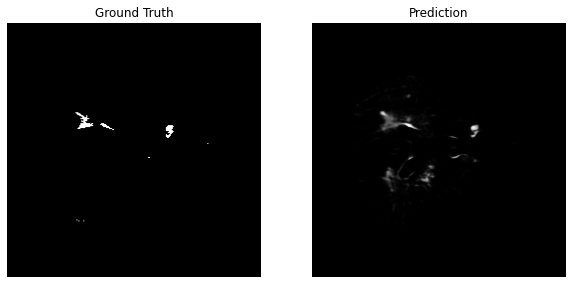

14/14 [==============================] - 12s 865ms/step - loss: 0.2623 - dice_coef: 0.2214


'Model AttX-enc have total params : 11,472,790'

In [ ]:
y_pred = md_AttXenc_ds.predict(img_test)
show_img(seg_z, y_pred, 16)
scores = md_AttXenc_ds.evaluate(img_test, seg_test)
'Model {} have total params : {:,}'.format(md_AttXenc_ds.name, md_AttXenc_ds.count_params())

# 2. Unet++


## 2.1. Encoder


In [ ]:
logdir = path+'logdir/Xnet'

tensorboard = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint(
    filepath=path+"Xnet/checkpoint-best-{epoch:02d}-{val_loss:.4f}.hdf5",
    monitor='val_loss', mode='min', save_best_only=True)

md_Xenc = model.Xnet(use_backbone=False, input_shape=(256,256,1),
                     n_upsample_blocks=n_blocks, decoder_filters=decoder_filters)

md_Xenc.compile(optimizer=Adam(learning_rate=lr), loss=binary_focal_loss(gamma=gamma, alpha=alpha), metrics=[dice_coef])

md_Xenc.fit(img_train, seg_train, epochs=epoch, batch_size=batch_size,
            validation_data=(img_val,seg_val),
            callbacks=[model_checkpoint, reduce_lr, tensorboard])

best_weight = find_best(path+'Xnet')
md_Xenc.load_weights(best_weight)

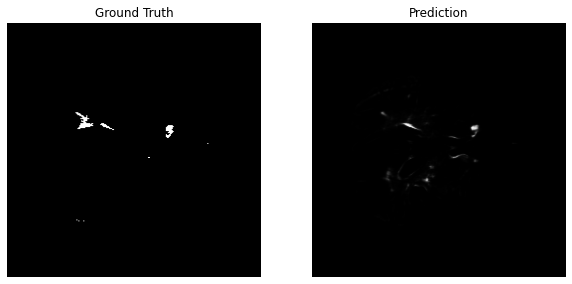

14/14 [==============================] - 8s 530ms/step - loss: 0.2451 - dice_coef: 0.3066


'Model X-enc have total params : 9,166,657'

In [ ]:
y_pred = md_Xenc.predict(img_test)
show_img(seg_z, y_pred, 16)
scores = md_Xenc.evaluate(img_test, seg_test)
'Model {} have total params : {:,}'.format(md_Xenc.name, md_Xenc.count_params())

## 2.2. Encoder and Deep Supervision


In [ ]:
logdir = path+'logdir/Xnet_ds'

tensorboard = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint(
    filepath=path+"Xnet_ds/checkpoint-best-{epoch:02d}-{val_loss:.4f}.hdf5",
    monitor='val_loss', mode='min', save_best_only=True)

md_Xenc_ds = model.Xnet(use_backbone=False, input_shape=(256,256,1), deep_supervision=True,
                     n_upsample_blocks=n_blocks, decoder_filters=decoder_filters)

md_Xenc_ds.compile(optimizer=Adam(learning_rate=lr), loss=binary_focal_loss(gamma=gamma, alpha=alpha), metrics=[dice_coef])

md_Xenc_ds.fit(img_train, seg_train, epochs=epoch, batch_size=batch_size,
            validation_data=(img_val,seg_val),
            callbacks=[model_checkpoint, reduce_lr, tensorboard])

best_weight = find_best(path+'Xnet_ds')
md_Xenc_ds.load_weights(best_weight)

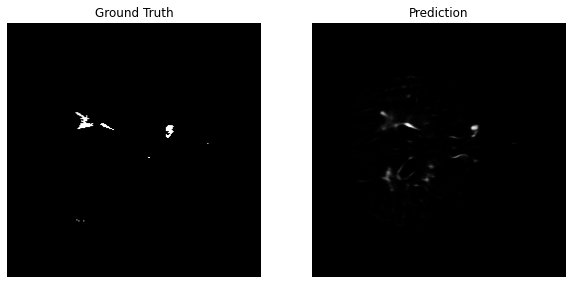

14/14 [==============================] - 7s 521ms/step - loss: 0.2577 - dice_coef: 0.1775


'Model X-enc have total params : 9,166,500'

In [ ]:
y_pred = md_Xenc_ds.predict(img_test)
show_img(seg_z, y_pred, 16)
scores = md_Xenc_ds.evaluate(img_test, seg_test)
'Model {} have total params : {:,}'.format(md_Xenc_ds.name, md_Xenc_ds.count_params())

# 3. Attention Unet


## 3.1. Encoder


In [ ]:
logdir = path+'logdir/AttUnet'

tensorboard = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint(
    filepath=path+"AttUnet/checkpoint-best-{epoch:02d}-{val_loss:.4f}.hdf5",
    monitor='val_loss', mode='min', save_best_only=True)

md_Attenc = model.Unet(use_backbone=False, input_shape=(256,256,1), attention=True,
                       n_upsample_blocks=n_blocks, decoder_filters=decoder_filters)

md_Attenc.compile(optimizer=Adam(learning_rate=lr), loss=binary_focal_loss(gamma=gamma, alpha=alpha), metrics=[dice_coef])

md_Attenc.fit(img_train, seg_train, epochs=epoch, batch_size=batch_size,
              validation_data=(img_val,seg_val),
              callbacks=[model_checkpoint, reduce_lr, tensorboard])

best_weight = find_best(path+'AttUnet')
md_Attenc.load_weights(best_weight)

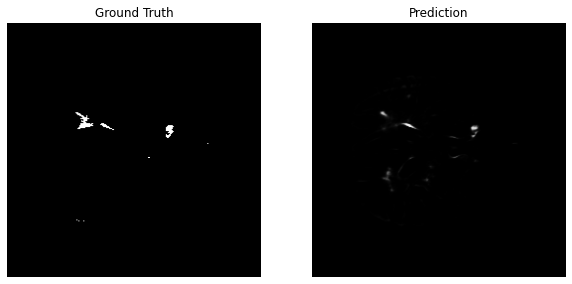

14/14 [==============================] - 5s 283ms/step - loss: 0.2479 - dice_coef: 0.3322


'Model AttU-enc have total params : 9,603,189'

In [ ]:
y_pred = md_Attenc.predict(img_test)
show_img(seg_z, y_pred, 16)
scores = md_Attenc.evaluate(img_test, seg_test)
'Model {} have total params : {:,}'.format(md_Attenc.name, md_Attenc.count_params())

# 4. Unet


## 4.1. Encoder


In [ ]:
logdir = path+'logdir/Unet'

tensorboard = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint(
    filepath=path+"Unet/checkpoint-best-{epoch:02d}-{val_loss:.4f}.hdf5",
    monitor='val_loss', mode='min', save_best_only=True)

md_enc = model.Unet(use_backbone=False, input_shape=(256,256,1), 
                    n_upsample_blocks=n_blocks, decoder_filters=decoder_filters)

md_enc.compile(optimizer=Adam(learning_rate=lr), loss=binary_focal_loss(gamma=gamma, alpha=alpha), metrics=[dice_coef])

md_enc.fit(img_train, seg_train, epochs=epoch, batch_size=batch_size,
           validation_data=(img_val,seg_val),
           callbacks=[model_checkpoint, reduce_lr, tensorboard])

best_weight = find_best(path+'Unet')
md_enc.load_weights(best_weight)

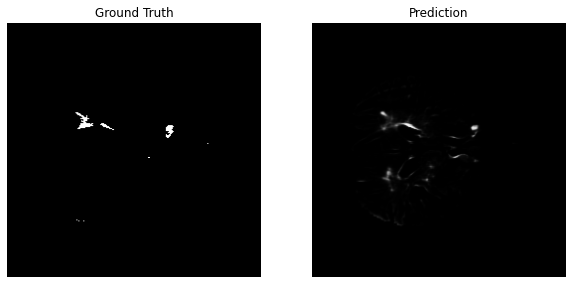

14/14 [==============================] - 3s 194ms/step - loss: 0.2496 - dice_coef: 0.2787


'Model U-enc have total params : 7,855,169'

In [ ]:
y_pred = md_enc.predict(img_test)
show_img(seg_z, y_pred, 16)
scores = md_enc.evaluate(img_test, seg_test)
'Model {} have total params : {:,}'.format(md_enc.name, md_enc.count_params())